In [27]:

%pip -q install imutils tqdm

import os
from pathlib import Path

import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
from tqdm import tqdm


Note: you may need to restart the kernel to use updated packages.


In [28]:
# Change these if your folders differ
TRAIN_ROOT = Path("/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Trainingbrain")
TEST_ROOT  = Path("/Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain")

OUT_TRAIN = Path("/Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Training")
OUT_TEST  = Path("/Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Testing")

IMG_SIZE = 256
THRESH_VAL = 45
ADD_PIXELS = 0

print("Train root:", TRAIN_ROOT)
print("Test root :", TEST_ROOT)
print("Out train :", OUT_TRAIN)
print("Out test  :", OUT_TEST)

Train root: /Users/shammi/Documents/Projects/BrainTumorProject/dataset/Trainingbrain
Test root : /Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain
Out train : /Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Training
Out test  : /Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Testing


In [29]:
def list_classes(root_dir: Path):
    return sorted([p.name for p in root_dir.iterdir() if p.is_dir() and not p.name.startswith(".")])

train_classes = list_classes(TRAIN_ROOT)
test_classes  = list_classes(TEST_ROOT)

print("Training classes:", train_classes)
print("Testing classes :", test_classes)

Training classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Testing classes : ['glioma', 'meningioma', 'notumor', 'pituitary']


In [4]:
def crop_img(bgr_img: np.ndarray, thresh_val: int = 45, add_pixels: int = 0) -> np.ndarray:
    """
    Finds the biggest contour and crops the rectangular ROI using extreme points.
    Expects BGR image from cv2.imread.
    """
    if bgr_img is None:
        return None

    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    mask = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY)[1]
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)

    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if not cnts:
        return bgr_img  # fallback

    c = max(cnts, key=cv2.contourArea)

    ext_left  = tuple(c[c[:, :, 0].argmin()][0])
    ext_right = tuple(c[c[:, :, 0].argmax()][0])
    ext_top   = tuple(c[c[:, :, 1].argmin()][0])
    ext_bot   = tuple(c[c[:, :, 1].argmax()][0])

    x0 = max(ext_left[0]  - add_pixels, 0)
    x1 = min(ext_right[0] + add_pixels, bgr_img.shape[1])
    y0 = max(ext_top[1]   - add_pixels, 0)
    y1 = min(ext_bot[1]   + add_pixels, bgr_img.shape[0])

    cropped = bgr_img[y0:y1, x0:x1].copy()
    return cropped if cropped.size else bgr_img

In [30]:
demo_path = TRAIN_ROOT / "meningioma" / "Tr-me_0016.jpg"
img = cv2.imread(str(demo_path))

if img is None:
    raise FileNotFoundError(f"Could not read: {demo_path}")

img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
cropped = crop_img(img, thresh_val=THRESH_VAL, add_pixels=ADD_PIXELS)

print("Original shape:", img.shape)
print("Cropped shape :", cropped.shape)

Original shape: (224, 224, 3)
Cropped shape : (152, 143, 3)


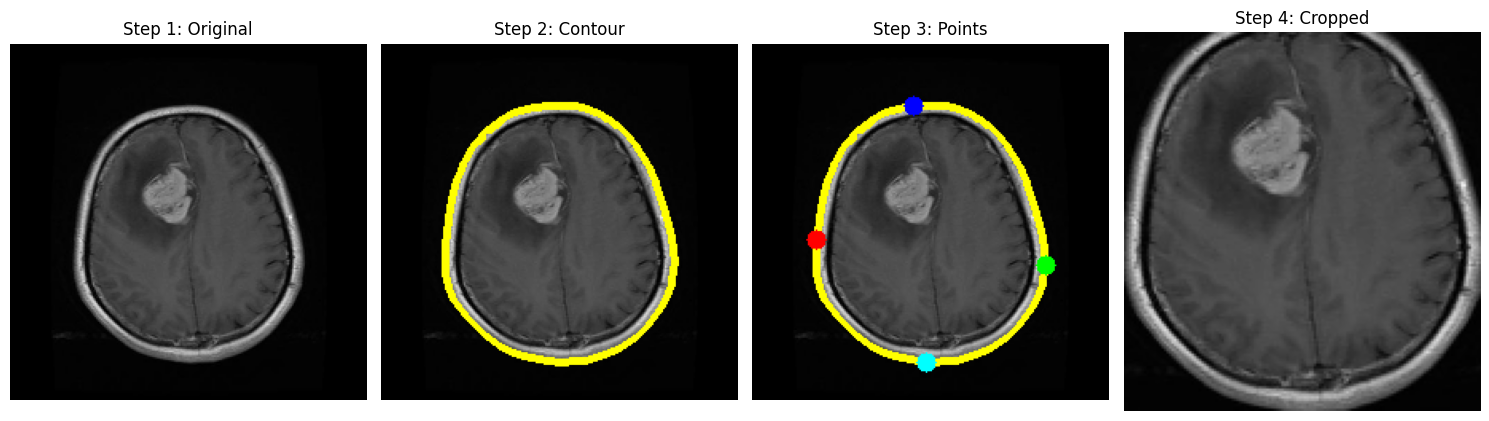

In [31]:
def demo_contour_and_points(bgr_img: np.ndarray, thresh_val=45):
    gray = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    mask = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY)[1]
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)

    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if not cnts:
        return bgr_img, bgr_img, bgr_img

    c = max(cnts, key=cv2.contourArea)

    extLeft  = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop   = tuple(c[c[:, :, 1].argmin()][0])
    extBot   = tuple(c[c[:, :, 1].argmax()][0])

    img_cnt = cv2.drawContours(bgr_img.copy(), [c], -1, (0, 255, 255), 3)

    img_pnt = img_cnt.copy()
    img_pnt = cv2.circle(img_pnt, extLeft,  6, (0, 0, 255),   -1)
    img_pnt = cv2.circle(img_pnt, extRight, 6, (0, 255, 0),   -1)
    img_pnt = cv2.circle(img_pnt, extTop,   6, (255, 0, 0),   -1)
    img_pnt = cv2.circle(img_pnt, extBot,   6, (255, 255, 0), -1)

    return bgr_img, img_cnt, img_pnt

to_rgb = lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

img0, img_cnt, img_pnt = demo_contour_and_points(img, thresh_val=THRESH_VAL)
new_img = crop_img(img, thresh_val=THRESH_VAL, add_pixels=ADD_PIXELS)

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1); plt.imshow(to_rgb(img0));    plt.title("Step 1: Original"); plt.axis("off")
plt.subplot(1, 4, 2); plt.imshow(to_rgb(img_cnt)); plt.title("Step 2: Contour");  plt.axis("off")
plt.subplot(1, 4, 3); plt.imshow(to_rgb(img_pnt)); plt.title("Step 3: Points");   plt.axis("off")
plt.subplot(1, 4, 4); plt.imshow(to_rgb(new_img)); plt.title("Step 4: Cropped");  plt.axis("off")
plt.tight_layout()
plt.show()

In [32]:
def process_split(src_root: Path, dst_root: Path, img_size: int, thresh_val: int, add_pixels: int):
    dst_root.mkdir(parents=True, exist_ok=True)

    class_names = list_classes(src_root)
    print(f"\nProcessing: {src_root}  ->  {dst_root}")
    print("Classes:", class_names)

    for cls in class_names:
        src_dir = src_root / cls
        out_dir = dst_root / cls
        out_dir.mkdir(parents=True, exist_ok=True)

        files = [p for p in src_dir.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
        for p in tqdm(files, desc=f"Cropping {cls}", leave=False):
            img_bgr = cv2.imread(str(p))
            if img_bgr is None:
                continue

            cropped = crop_img(img_bgr, thresh_val=thresh_val, add_pixels=add_pixels)
            cropped = cv2.resize(cropped, (img_size, img_size))
            cv2.imwrite(str(out_dir / p.name), cropped)

In [33]:
process_split(
    src_root=TRAIN_ROOT,
    dst_root=OUT_TRAIN,
    img_size=IMG_SIZE,
    thresh_val=THRESH_VAL,
    add_pixels=ADD_PIXELS
)


Processing: /Users/shammi/Documents/Projects/BrainTumorProject/dataset/Trainingbrain  ->  /Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Training
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [9]:
process_split(
    src_root=TEST_ROOT,
    dst_root=OUT_TEST,
    img_size=IMG_SIZE,
    thresh_val=THRESH_VAL,
    add_pixels=ADD_PIXELS
)



Processing: /Users/shammi/Documents/Projects/BrainTumorProject/dataset/Testingbrain  ->  /Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Testing
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [34]:
def count_images_per_class(root_dir: Path):
    counts = {}
    for cls in list_classes(root_dir):
        cls_dir = root_dir / cls
        counts[cls] = len([p for p in cls_dir.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png"]])
    return counts

train_out_counts = count_images_per_class(OUT_TRAIN)
test_out_counts  = count_images_per_class(OUT_TEST)

print("Cropped TRAIN counts:", train_out_counts)
print("Cropped TEST counts :", test_out_counts)

Cropped TRAIN counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Cropped TEST counts : {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


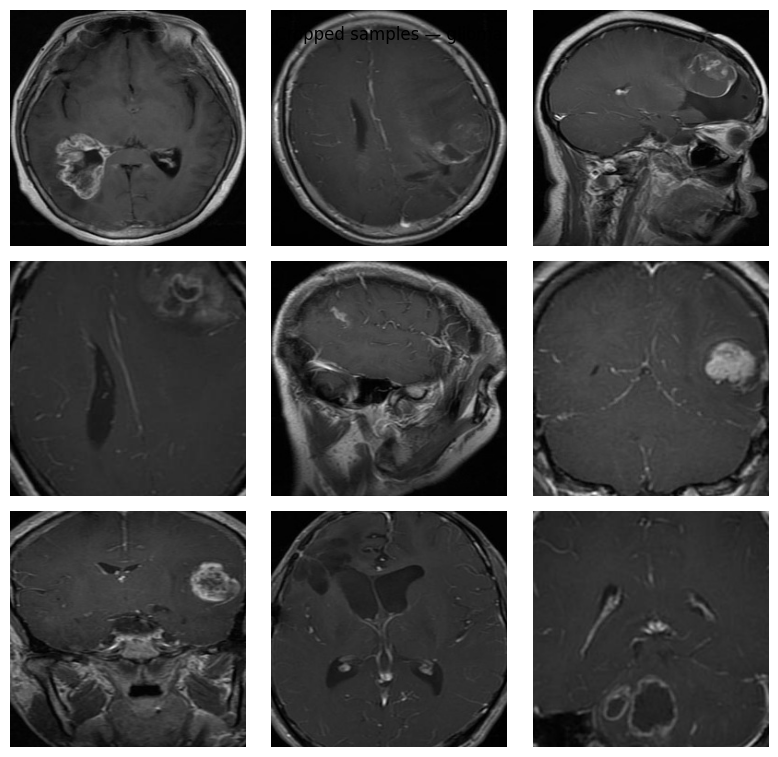

In [35]:
sample_class = train_classes[0] if train_classes else "meningioma"
sample_dir = OUT_TRAIN / sample_class
sample_files = [p for p in sample_dir.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png"]][:9]

plt.figure(figsize=(8, 8))
for i, p in enumerate(sample_files):
    img_bgr = cv2.imread(str(p))
    if img_bgr is None:
        continue
    plt.subplot(3, 3, i + 1)
    plt.imshow(to_rgb(img_bgr))
    plt.axis("off")
plt.suptitle(f"Cropped samples — {sample_class}", y=0.92)
plt.tight_layout()
plt.show()

In [36]:
import os
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [37]:
OUT_TRAIN = Path("/Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Training")
OUT_TEST  = Path("/Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Testing")

CLASSES = ["glioma", "meningioma", "notumor", "pituitary"]
NUM_CLASSES = len(CLASSES)

IMAGE_SIZE = 200
IMG_SIZE = (IMAGE_SIZE, IMAGE_SIZE)

BATCH_SIZE = 28
EPOCHS = 65

print("Cropped train:", OUT_TRAIN)
print("Cropped test :", OUT_TEST)

Cropped train: /Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Training
Cropped test : /Users/shammi/Documents/Projects/BrainTumorProject/dataset/cropped/Testing


Class frequency counts:
Class: notumor, Count: 2000 images
Class: pituitary, Count: 1757 images
Class: meningioma, Count: 1645 images
Class: glioma, Count: 1621 images

Total dataset size is: 7023 images
Number of classes: 4 classes


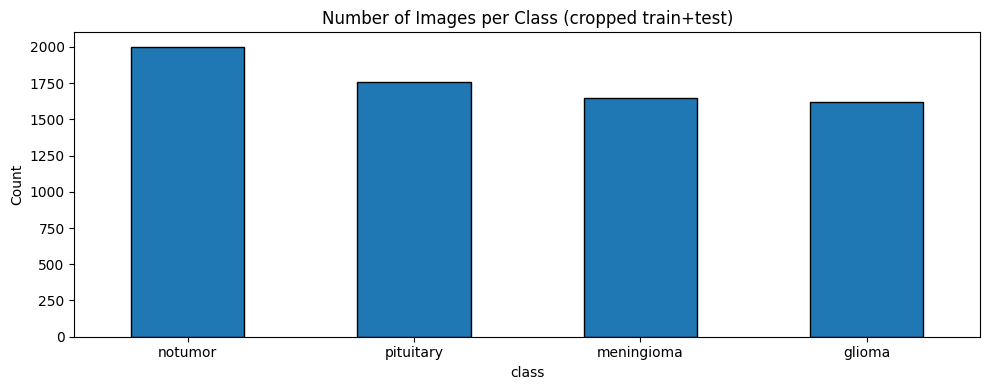

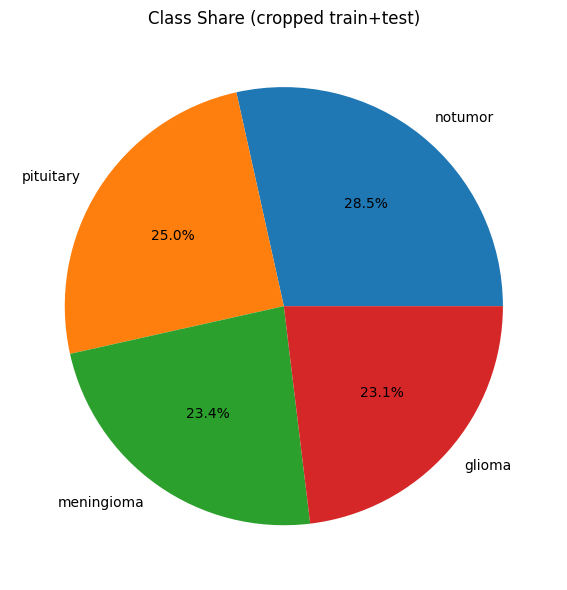

In [38]:
import pandas as pd

def index_images(root_dir: Path, class_names: list[str]) -> pd.DataFrame:
    rows = []
    for cls in class_names:
        cls_dir = root_dir / cls
        if not cls_dir.exists():
            continue
        for p in cls_dir.iterdir():
            if p.suffix.lower() in [".jpg", ".jpeg", ".png"]:
                rows.append({"path": str(p), "class": cls})
    return pd.DataFrame(rows)

df_train = index_images(OUT_TRAIN, CLASSES)
df_test  = index_images(OUT_TEST, CLASSES)
df_all = pd.concat([df_train.assign(split="train"), df_test.assign(split="test")], ignore_index=True)

class_count = df_all["class"].value_counts()
print("Class frequency counts:")
for cls, cnt in class_count.items():
    print(f"Class: {cls}, Count: {cnt} images")

print(f"\nTotal dataset size is: {len(df_all)} images")
print(f"Number of classes: {df_all['class'].nunique()} classes")

plt.figure(figsize=(10, 4))
class_count.plot(kind="bar", edgecolor="black")
plt.title("Number of Images per Class (cropped train+test)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
class_count.plot(kind="pie", autopct="%1.1f%%")
plt.title("Class Share (cropped train+test)")
plt.ylabel("")
plt.tight_layout()
plt.show()

In [39]:
def load_split_from_folders(root_dir: Path, class_names: list[str], image_size=(200, 200)):
    X, y = [], []
    for cls_idx, cls_name in enumerate(class_names):
        folder = root_dir / cls_name
        if not folder.exists():
            raise FileNotFoundError(f"Missing folder: {folder}")

        files = [p for p in folder.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
        for p in tqdm(files, desc=f"Loading {cls_name}", leave=False):
            gray = cv2.imread(str(p), 0)
            if gray is None:
                continue

            gray = cv2.bilateralFilter(gray, 2, 50, 50) #denoise
            pseudo = cv2.applyColorMap(gray, cv2.COLORMAP_BONE)  # BGR
            pseudo = cv2.resize(pseudo, image_size)

            X.append(pseudo)
            y.append(cls_idx)

    X = np.array(X, dtype=np.float32) / 255.0 #normalizes images to the range 0–1
    y = np.array(y, dtype=np.int32)
    return X, y

X_train_all, y_train_all = load_split_from_folders(OUT_TRAIN, CLASSES, image_size=IMG_SIZE)
X_test, y_test = load_split_from_folders(OUT_TEST, CLASSES, image_size=IMG_SIZE)

print("Train:", X_train_all.shape, y_train_all.shape)
print("Test :", X_test.shape, y_test.shape)

Train: (5712, 200, 200, 3) (5712,)
Test : (1311, 200, 200, 3) (1311,)


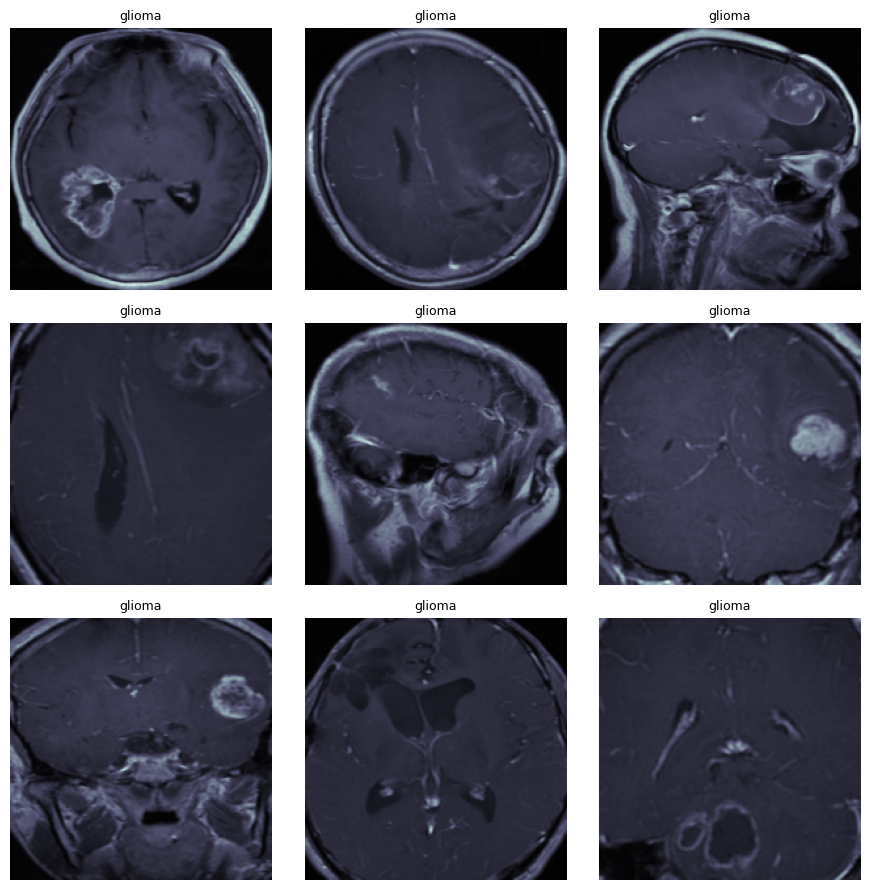

In [40]:
plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)

    img_bgr = (X_train_all[i] * 255).astype(np.uint8)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.title(CLASSES[int(y_train_all[i])], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [41]:
X_train_all, y_train_all = shuffle(X_train_all, y_train_all, random_state=37)

y_train_all_oh = tf.keras.utils.to_categorical(y_train_all, num_classes=NUM_CLASSES)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

print("y_train_all_oh:", y_train_all_oh.shape)
print("y_test_oh     :", y_test_oh.shape)

y_train_all_oh: (5712, 4)
y_test_oh     : (1311, 4)


In [42]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all_oh, test_size=0.2, random_state=27
)

print("X_train:", X_train.shape)
print("X_val  :", X_val.shape)
print("X_test :", X_test.shape)

print("\nTraining set class counts:", np.sum(y_train, axis=0).astype(int))
print("Validation set class counts:", np.sum(y_val, axis=0).astype(int))
print("Testing set class counts:", np.sum(y_test_oh, axis=0).astype(int))

X_train: (4569, 200, 200, 3)
X_val  : (1143, 200, 200, 3)
X_test : (1311, 200, 200, 3)

Training set class counts: [1049 1060 1282 1178]
Validation set class counts: [272 279 313 279]
Testing set class counts: [300 306 405 300]


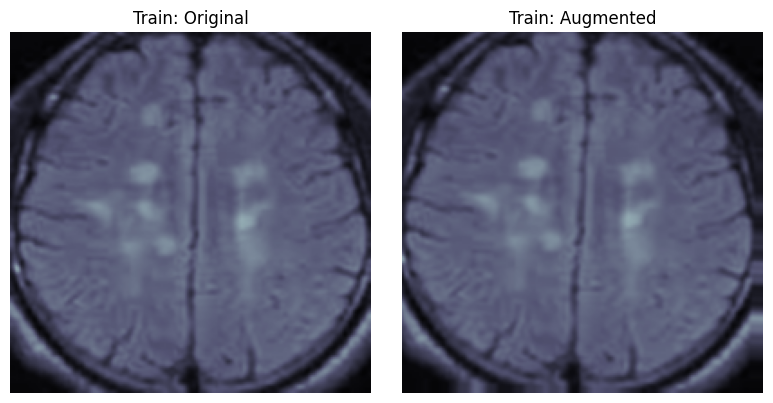

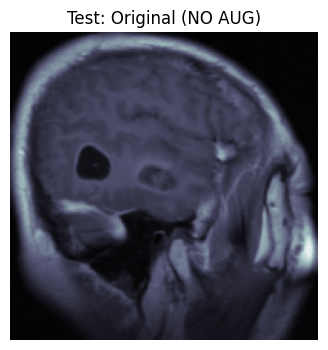

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.005,
    horizontal_flip=False,   # IMPORTANT: 'true' is high risk for brain MRI! Flipping can invert hemispheres.
    fill_mode="nearest"      # Left-right symmetry is not anatomically interchangeable.
)

augmenter.fit(X_train)

train_flow = augmenter.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)

# ---- Visual sanity check: original vs augmented ----
idx = 0
orig = X_train[idx]
aug = next(augmenter.flow(orig[np.newaxis, ...], batch_size=1, shuffle=False))[0]

def show_bgr01(img01, title):
    img_bgr = (img01 * 255).astype(np.uint8)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1); show_bgr01(orig, "Train: Original")
plt.subplot(1, 2, 2); show_bgr01(aug,  "Train: Augmented")
plt.tight_layout()
plt.show()

# ---- Test sample to emphasize NO augmentation on test ----
plt.figure(figsize=(4, 4))
test_img_bgr = (X_test[0] * 255).astype(np.uint8)
plt.imshow(cv2.cvtColor(test_img_bgr, cv2.COLOR_BGR2RGB))
plt.title("Test: Original (NO AUG)")
plt.axis("off")
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Build a summary table
df_shapes = pd.DataFrame({
    "Split": ["Train", "Validation", "Test"],
    "X shape": [X_train.shape, X_val.shape, X_test.shape],
    "y shape": [y_train.shape, y_val.shape, y_test_oh.shape],
    "Samples": [X_train.shape[0], X_val.shape[0], X_test.shape[0]],
    "Image size": [f"{X_train.shape[1]}×{X_train.shape[2]}"] * 3,
    "Channels": [X_train.shape[3], X_val.shape[3], X_test.shape[3]],
    "Classes": [y_train.shape[1], y_val.shape[1], y_test_oh.shape[1]],
})

display(df_shapes)

# Render as a boxed image
fig, ax = plt.subplots(figsize=(12, 2.8))
ax.axis("off")

tbl = ax.table(
    cellText=df_shapes.values,
    colLabels=df_shapes.columns,
    cellLoc="center",
    loc="center"
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

plt.title("Dataset Split Summary (RGB MRI, One-Hot Labels)", pad=12)

out_path = "dataset_split_summary.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved box image to:", out_path)

In [ ]:
import numpy as np
import pandas as pd

class_names = CLASSES  # e.g. ["glioma", "meningioma", "notumor", "pituitary"] adjust labels if needed

def class_counts(one_hot):
    return np.sum(one_hot, axis=0).astype(int)

train_counts = class_counts(y_train)
val_counts   = class_counts(y_val)
test_counts  = class_counts(y_test_oh)

df = pd.DataFrame({
    "Category": class_names,
    "Training": train_counts,
    "Validation": val_counts,
    "Testing": test_counts,
})

# Add total row
totals = pd.DataFrame([{
    "Category": "Total",
    "Training": int(train_counts.sum()),
    "Validation": int(val_counts.sum()),
    "Testing": int(test_counts.sum()),
}])

df = pd.concat([df, totals], ignore_index=True)

df

In [ ]:
import matplotlib.pyplot as plt

# Colors
HEADER_COLOR = "#E9EEF6"
COL_HIGHLIGHT = "#B9D9FF"   # light blue like your screenshot
GRID_COLOR = "#C9D3E1"
TOTAL_BG = "#F3F6FB"

fig, ax = plt.subplots(figsize=(9.5, 3.2))
ax.axis("off")

# Title + subtitle (optional)
ax.text(0.0, 1.08, "Dataset Details and Distribution", fontsize=16, fontweight="bold", transform=ax.transAxes)
ax.text(0.0, 1.01, "The dataset is partitioned into training, validation, and testing sets as outlined below:",
        fontsize=10.5, transform=ax.transAxes)

# Table content
cell_text = df.values.tolist()
col_labels = df.columns.tolist()

table = ax.table(
    cellText=cell_text,
    colLabels=col_labels,
    cellLoc="center",
    colLoc="center",
    loc="upper left",
    bbox=[0.0, 0.0, 0.92, 0.9]  # left, bottom, width, height
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.6)

n_rows = len(df) + 1  # +1 header
n_cols = len(col_labels)

# Style header
for c in range(n_cols):
    cell = table[(0, c)]
    cell.set_facecolor(HEADER_COLOR)
    cell.set_edgecolor(GRID_COLOR)
    cell.set_linewidth(1.0)
    cell.get_text().set_fontweight("bold")

# Style body cells + grid
for r in range(1, n_rows):
    for c in range(n_cols):
        cell = table[(r, c)]
        cell.set_edgecolor(GRID_COLOR)
        cell.set_linewidth(0.8)

        # Highlight Training/Validation/Testing columns
        if c in [1, 2, 3] and r < n_rows - 1:  # not total row
            cell.set_facecolor(COL_HIGHLIGHT)

        # Total row styling
        if r == n_rows - 1:
            cell.set_facecolor(TOTAL_BG)
            cell.get_text().set_fontweight("bold")
            cell.set_linewidth(1.2)

# Left-align the "Category" column text
for r in range(1, n_rows):
    table[(r, 0)].get_text().set_ha("left")
    table[(r, 0)].PAD = 0.02

out_path = "dataset_distribution_table.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight", pad_inches=0.15)
plt.show()

print("Saved image to:", out_path)